In [76]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline  
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [77]:
given_train_data = pd.read_csv("/kaggle/input/marketing-strategy-personalised-offer/train_data.csv")  # copy file path and paste it
given_test_data = pd.read_csv("/kaggle/input/marketing-strategy-personalised-offer/test_data.csv")
given_train_data.head(10)

,offer expiration,income_range,no_visited_Cold drinks,travelled_more_than_15mins_for_offer,Restaur_spend_less_than20,Marital Status,restaurant type,age,Prefer western over chinese,travelled_more_than_25mins_for_offer,...,restuarant_opposite_direction_house,has Children,visit restaurant with rating (avg),temperature,Restaur_spend_greater_than20,Travel Time,Climate,drop location,Prefer home food,Offer Accepted
0,2days,₹100000 or More,4~8,1,less1,Married partner,4 star restaurant,36,0,0,...,0,0,4,67,less1,22,Spring,Location B,0,No
1,2days,₹87500 - ₹99999,4~8,0,4~8,Married partner,Take-away restaurant,50plus,0,0,...,0,1,3,89,1~3,18,Summer,Location B,0,Yes
2,2days,₹87500 - ₹99999,less1,1,1~3,Single,Cold drinks,26,1,0,...,1,1,4,67,less1,7,Winter,Location A,1,Yes
3,10hours,₹37500 - ₹49999,less1,0,1~3,Single,Take-away restaurant,46,1,0,...,0,1,3,89,1~3,7,Summer,Location C,0,No
4,2days,₹100000 or More,never,1,1~3,Single,4 star restaurant,21,0,1,...,1,0,3,40,less1,7,Summer,Location C,0,No
5,10hours,Less than ₹12500,4~8,1,gt8,Divorced,Take-away restaurant,50plus,1,0,...,1,0,0,40,less1,22,Spring,Location C,0,Yes
6,2days,Less than ₹12500,less1,1,1~3,Single,Cold drinks,below21,0,0,...,0,0,0,89,never,7,Spring,Location C,0,Yes
7,2days,₹50000 - ₹62499,never,1,1~3,Married partner,Restaurant with pub,50plus,0,0,...,1,1,0,40,less1,10,Summer,Location B,0,No
8,10hours,₹12500 - ₹24999,less1,1,less1,Single,Restaurant with pub,41,1,0,...,1,1,1,89,never,7,Summer,Location C,0,No
9,10hours,₹75000 - ₹87499,4~8,1,1~3,Married partner,4 star restaurant,41,1,0,...,1,1,0,67,less1,22,Winter,Location B,0,Yes


In [78]:
print(given_train_data.isnull().sum())
given_train_data.shape

offer expiration                            0
income_range                                0
no_visited_Cold drinks                    198
travelled_more_than_15mins_for_offer        0
Restaur_spend_less_than20                 121
Marital Status                              0
restaurant type                             0
age                                         0
Prefer western over chinese                 0
travelled_more_than_25mins_for_offer        0
travelled_more_than_5mins_for_offer         0
no_visited_bars                            93
gender                                      0
car                                     12268
restuarant_same_direction_house             0
Cooks regularly                             0
Customer type                               0
Qualification                               0
is foodie                                   0
no_Take-aways                             144
Job/Job Industry                            0
restuarant_opposite_direction_hous

(12379, 31)

# clean the given training Data

### drop car column and the 5% observations which are null 

In [79]:
# drop the car column because it has 99% blanks
given_train_data.drop(["car"], axis = 1, inplace=True)
given_test_data.drop(["car"], axis = 1, inplace=True)

# drop the observations which has empty values, 5% obs
# given_train_data.dropna(axis = 0, inplace = True)
# reset the index after u drop the observation
# given_train_data.reset_index(inplace = True)

# fill all null values in the given test data, you strictly need 5305 rows 
# so dont drop any rows with null values instead fill the null values
given_test_data.fillna(value = 0, inplace = True)

In [80]:
given_test_data.isnull().sum()

offer expiration                        0
income_range                            0
no_visited_Cold drinks                  0
travelled_more_than_15mins_for_offer    0
Restaur_spend_less_than20               0
Marital Status                          0
restaurant type                         0
age                                     0
Prefer western over chinese             0
travelled_more_than_25mins_for_offer    0
travelled_more_than_5mins_for_offer     0
no_visited_bars                         0
gender                                  0
restuarant_same_direction_house         0
Cooks regularly                         0
Customer type                           0
Qualification                           0
is foodie                               0
no_Take-aways                           0
Job/Job Industry                        0
restuarant_opposite_direction_house     0
has Children                            0
visit restaurant with rating (avg)      0
temperature                       

### Clean the required columns

In [81]:
# A function made to replace any values from the data
def replace(train_data, test_data,replace_what, replace_with):
    train_data.replace(to_replace = replace_what, value = replace_with, inplace = True)
    test_data.replace(to_replace = replace_what, value = replace_with, inplace = True)
    

# call the function to clean the data from various columns

# "offer expiration" column
replace(given_train_data,given_test_data,'2days',48)
replace(given_train_data,given_test_data,'10hours',10)

# "age" column
replace(given_train_data,given_test_data,'50plus',54)
replace(given_train_data,given_test_data,'below21',20)

# "no_visited_Cold drinks", "Restaur_spend_less_than20",
# "no_visited_bars", "no_Take-aways",
# "Restaur_spend_greater_than20"


replace(given_train_data,given_test_data,"4~8",6)
replace(given_train_data,given_test_data,"1~3",2)
replace(given_train_data,given_test_data,"gt8",8)
replace(given_train_data,given_test_data,"less1",1)
replace(given_train_data,given_test_data,"never",0)

#### clean "income range column"

In [82]:
# we will split the income range into low range and high range
given_train_data["low_income_range"] = 1  
given_train_data["high_income_range"] = 2  

#create for test data as well
given_test_data["low_income_range"] = 1
given_test_data["high_income_range"] = 2

def income_range(dataframe):
    for i in range(dataframe.shape[0]):
        if dataframe["income_range"][i] == "₹100000 or More":
            dataframe["low_income_range"][i] = 100000 # 1lacs
            dataframe["high_income_range"][i] = 1000000 # 10lacs
        
        elif dataframe["income_range"][i] == "Less than ₹12500":
            dataframe["low_income_range"][i] = 5000 
            dataframe["high_income_range"][i] = 12500
        else:
            dataframe["low_income_range"][i] = int(dataframe["income_range"][i][1:6])
            dataframe["high_income_range"][i] = int(dataframe["income_range"][i][10:])
    
    return dataframe
        

given_train_data = income_range(given_train_data)
given_test_data = income_range(given_test_data)

# above code works so now remove the old income range column
given_train_data.drop(["income_range"],axis = 1,inplace=True)
given_test_data.drop(["income_range"],axis = 1,inplace=True)

In [83]:
given_train_data.isnull().sum()

offer expiration                          0
no_visited_Cold drinks                  198
travelled_more_than_15mins_for_offer      0
Restaur_spend_less_than20               121
Marital Status                            0
restaurant type                           0
age                                       0
Prefer western over chinese               0
travelled_more_than_25mins_for_offer      0
travelled_more_than_5mins_for_offer       0
no_visited_bars                          93
gender                                    0
restuarant_same_direction_house           0
Cooks regularly                           0
Customer type                             0
Qualification                             0
is foodie                                 0
no_Take-aways                           144
Job/Job Industry                          0
restuarant_opposite_direction_house       0
has Children                              0
visit restaurant with rating (avg)        0
temperature                     

In [84]:
# extract the columns since u need them to convert the imputed
# train set back to the dataframe
data_columns = list(given_train_data.columns)
data_columns

from sklearn.impute import SimpleImputer

si = SimpleImputer(strategy = 'most_frequent', missing_values= np.nan)

given_train_data = si.fit_transform(given_train_data)

given_train_data = pd.DataFrame(given_train_data,columns = data_columns)

In [85]:
given_train_data.isnull().sum()


offer expiration                        0
no_visited_Cold drinks                  0
travelled_more_than_15mins_for_offer    0
Restaur_spend_less_than20               0
Marital Status                          0
restaurant type                         0
age                                     0
Prefer western over chinese             0
travelled_more_than_25mins_for_offer    0
travelled_more_than_5mins_for_offer     0
no_visited_bars                         0
gender                                  0
restuarant_same_direction_house         0
Cooks regularly                         0
Customer type                           0
Qualification                           0
is foodie                               0
no_Take-aways                           0
Job/Job Industry                        0
restuarant_opposite_direction_house     0
has Children                            0
visit restaurant with rating (avg)      0
temperature                             0
Restaur_spend_greater_than20      

# Pipeline

In [86]:
# first seperate X and y

X = given_train_data.drop(["Offer Accepted"],axis = 1)
y = given_train_data["Offer Accepted"]

# now divide the data into train and test using traintestsplit
X_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state = 42)


numeric_transformer = Pipeline(steps = [("scaler", StandardScaler())])  

n_cols = ['offer expiration','low_income_range','high_income_range',
'no_visited_Cold drinks','travelled_more_than_15mins_for_offer',
'Restaur_spend_less_than20','age','Prefer western over chinese',
'travelled_more_than_25mins_for_offer','travelled_more_than_5mins_for_offer',
'no_visited_bars','restuarant_same_direction_house',
'Cooks regularly','is foodie','restuarant_opposite_direction_house',
'has Children','visit restaurant with rating (avg)','temperature',
'Travel Time','Prefer home food','no_Take-aways','Restaur_spend_greater_than20']  # 21 total numerical variables

categorical_transformer = OneHotEncoder()
c_cols = ["Marital Status",'gender', "Customer type","Qualification","Job/Job Industry","Climate","drop location","restaurant type"]

preprocessor = ColumnTransformer(transformers = [("num", numeric_transformer,n_cols),                        
                     ("cat_ohe",categorical_transformer, c_cols ) ] , 
                     remainder = "passthrough")


X_train = preprocessor.fit_transform(X_train)

x_test = preprocessor.transform(x_test)  # only transform not fit_transform

In [87]:
# attach the index column to the given test data
given_test_data["index"] = [i for i in range(len(given_test_data))]

given_test_data = preprocessor.transform(given_test_data)


### handle the mild class imbalance

In [88]:
# NO is the minority class

print("test imbalance:", (np.count_nonzero(y_test == "No"))  /  (len(y_test)) )

print()

print("train imbalance:", (np.count_nonzero(y_train == "No"))  /  (len(y_train)) )


from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(preprocessor.transform(X)  , y)


test imbalance: 0.4439956919763059

train imbalance: 0.4311598384304674


# split into train and test

In [89]:
# first seperate X and y

X = given_train_data.drop(["Offer Accepted"],axis = 1)
y = given_train_data["Offer Accepted"]

# now divide the data into train and test using traintestsplit
X_train,x_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size=0.30,random_state=42)

print()

print("test imbalance:", (np.count_nonzero(y_test == "No"))  /  (len(y_test)) )
print("train imbalance:", (np.count_nonzero(y_train == "No"))  /  (len(y_train)) )


test imbalance: 0.5034548487014534
train imbalance: 0.49851904810540293


In [90]:
# run the randomforest with default parameter values
rf = RandomForestClassifier(random_state = 1200)
rf.fit(X_train, y_train)

print("Test Score",rf.score(x_test,y_test))  #0.6726, score after hyperparatuning is 0.6378653113087674
print("Train score:",rf.score(X_train,y_train))

y_pred_test = rf.predict(x_test)

precision,recall,fscore,support = score(y_test,y_pred_test,average = "macro")
print('F1-score : {},'.format(fscore))

Test Score 0.6835835120324041
Train score: 1.0
F1-score : 0.6815056187788173,


### Hyperparameter Tun (for RFC) using RandomSearchCV

In [91]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 15)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 20)]
max_depth.append(None)#  append the default None in the end
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# convert y_train from yes/no to 1/0 for randomized search
y_train.replace(to_replace="Yes", value = 1, inplace = True)
y_train.replace(to_replace="No", value = 0, inplace = True)

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 25, cv = 3, verbose=3, random_state=1200, n_jobs = -1,scoring ='f1' )



In [92]:
# Fit the random search model
# rf_random.fit(X_train,y_train)
# rf_random.best_params_

### Train the Random Forest classifier using best parameters

In [93]:
# replace the 1 and 0 by yes and no
y_train.replace(to_replace=1, value = "Yes", inplace = True)
y_train.replace(to_replace=0, value = "No", inplace = True)

test = []
train = []

for i in range(1,20):
    
    rf = RandomForestClassifier(n_estimators=186, min_samples_split=4, min_samples_leaf=3,max_features='log2',max_depth=i,bootstrap= True,random_state = 1200)
    rf.fit(X_train, y_train)
    test.append(rf.score(x_test,y_test))
    train.append(rf.score(X_train,y_train))

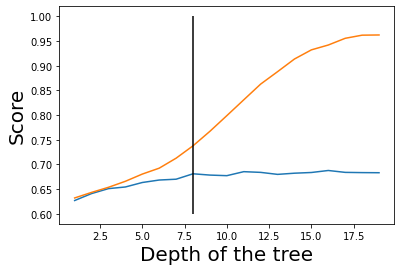

In [94]:
# define data values
y = [i for i in range(1,20)]  
plt.plot(y, test)  # Plot the chart (x, y)
plt.plot(y, train)
plt.vlines(x = 8,ymin = 0.6, ymax = 1,colors = 'black')
plt.xlabel('Depth of the tree', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.show()
# hence depth = 8

In [95]:
# # replace the 1 and 0 by yes and no
y_train.replace(to_replace=1, value = "Yes", inplace = True)
y_train.replace(to_replace=0, value = "No", inplace = True)

rf = RandomForestClassifier(n_estimators=186, min_samples_split=4, min_samples_leaf=3,max_features='log2',max_depth=8,bootstrap= True,random_state = 1200)
rf.fit(X_train, y_train)

y_pred_test = rf.predict(x_test) # predictions on validation test data

print("Test Score",rf.score(x_test,y_test)) 
print("Train score:",rf.score(X_train,y_train))
precision,recall,fscore,support = score(y_test,y_pred_test,average = "macro")
print('F1-score : {},'.format(fscore))

Test Score 0.6812008577555396
Train score: 0.7378204473496068
F1-score : 0.678717369901837,


In [96]:
# View confusion matrix for test data and predictions
print(confusion_matrix(y_test, y_pred_test))
print()
print(classification_report(y_test, y_pred_test))
print()

[[1245  868]
 [ 470 1614]]

              precision    recall  f1-score   support

          No       0.73      0.59      0.65      2113
         Yes       0.65      0.77      0.71      2084

    accuracy                           0.68      4197
   macro avg       0.69      0.68      0.68      4197
weighted avg       0.69      0.68      0.68      4197




In [97]:
# y_pred_test = rf.predict(x_test) # predictions on validation test data

# predictions = rf.predict(given_test_data) # predictions on given test data
#                             # not the splitted up test data from train set

# submission = pd.DataFrame(columns=["id", "Offer Accepted"])  # create an empty dataframe with two columns namely "id" and "offer Accepted"
# submission["id"] = [i for i in range(len(predictions))]  # id is nothing just serial number
# submission["Offer Accepted"] = predictions
# submission.to_csv("submission.csv",index = False)

# # submission.head()

# Try different models

### Gradient boost classifier

In [98]:
y_train.replace(to_replace=1, value = "Yes", inplace = True)
y_train.replace(to_replace=0, value = "No", inplace = True)

gbc = GradientBoostingClassifier(random_state = 1200)  # train a dummy model with default parameter 
gbc.fit(X_train,y_train)

y_pred_test = gbc.predict(x_test) # predictions on validation test data

print("Test Score",gbc.score(x_test,y_test)) 
print("Train score:",gbc.score(X_train,y_train))
precision,recall,fscore,support = score(y_test,y_pred_test,average = "macro")
print('F1-score : {},'.format(fscore))

Test Score 0.6745294257803193
Train score: 0.6956388520069452
F1-score : 0.6712529118228034,


In [99]:
# get an idea of the parameter which gave a test score of 0.67998
gbc.get_params(deep = True)

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 1200,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [100]:
# # narrow down the hyperparameters with gridsearchcv
# grid_param = {
#     "n_estimators":[int(x) for x in np.linspace(start = 75, stop = 800, num = 30)],
#     "max_depth":[int(x) for x in np.linspace(2,6, num = 5)],
#     "learning_rate":[0.01,0.1,1]
#              }
    
# RScv = RandomizedSearchCV(n_iter = 10 , estimator = gbc,param_distributions = grid_param,cv=5, verbose=1)
# RScv.fit(X_train,y_train)

# RScv.best_params_

In [101]:
gbc = GradientBoostingClassifier(n_estimators = 500, max_depth = 3, learning_rate=0.1,random_state = 1200)
gbc.fit(X_train,y_train)

y_pred_test = gbc.predict(x_test) # predictions on validation test data

print("Test Score",gbc.score(x_test,y_test))
print("Train score:",gbc.score(X_train,y_train))
precision,recall,fscore,support = score(y_test,y_pred_test,average = "macro")
print('F1-score : {},'.format(fscore))

Test Score 0.6761972837741244
Train score: 0.7674394852415484
F1-score : 0.673903494416098,


### XGboost classifier

In [102]:
y_train.replace(to_replace="Yes", value = 1, inplace = True)
y_train.replace(to_replace="No", value = 0, inplace = True)

y_test.replace(to_replace="Yes", value = 1, inplace = True)
y_test.replace(to_replace="No", value = 0, inplace = True)

xgb = XGBClassifier(random_state = 1200) # run a dummy model with default parameters
xgb.fit(X_train,y_train)
y_pred_test = xgb.predict(x_test)
print("Test Score:", xgb.score(x_test,y_test))
print("Train Score:", xgb.score(X_train,y_train))

precision,recall,fscore,support = score(y_test,y_pred_test,average = "macro")
print('F1-score : {}'.format(fscore))

Test Score: 0.6573743149868954
Train Score: 0.9203350015320192
F1-score : 0.6563332363026101


## tune hyperparameters for xgboost

In [103]:
# param_test1 = {
#     'learning_rate':[0.01, 0.1, 1, 10],
#      'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 1000, num = 7)],
#      'max_depth': [3,4,5,7,9,10],
#      'min_child_weight':range(1,6,2)
# }
# gsearch1 = RandomizedSearchCV(estimator = xgb,n_iter = 100, param_distributions = param_test1,cv =2 , verbose = 2)

# gsearch1.fit(X_train,y_train)

In [104]:
# gsearch1.best_params_

In [105]:
xgb = XGBClassifier(learning_rate =0.1, n_estimators=500, max_depth = 3,min_child_weight= 1,random_state = 42) 
# train the model using best hyperparameters
xgb.fit(X_train,y_train)

y_pred_test = xgb.predict(x_test)

print("Test Accuracy Score:", xgb.score(x_test,y_test))
print("Train Accuracy Score:", xgb.score(X_train,y_train))


precision,recall,fscore,support = score(y_test,y_pred_test,average = "macro")
print('F1-score : {}'.format(fscore))

Test Accuracy Score: 0.6750059566356922
Train Accuracy Score: 0.7518128893882137
F1-score : 0.6724742096757141


In [106]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.72      0.58      0.64      2113
           1       0.65      0.77      0.70      2084

    accuracy                           0.68      4197
   macro avg       0.68      0.68      0.67      4197
weighted avg       0.68      0.68      0.67      4197



In [107]:
# predictions = xgb.predict(given_test_data) 


# submission = pd.DataFrame(columns=["id", "Offer Accepted"])  # create an empty dataframe with two columns namely "id" and "offer Accepted"
# submission["id"] = [i for i in range(len(predictions))]  # id is nothing just serial number
# submission["Offer Accepted"] = predictions

# submission

# submission['Offer Accepted'].replace(to_replace=1, value = "Yes", inplace = True)
# submission['Offer Accepted'].replace(to_replace=0, value = "No",inplace = True)
# # submission.to_csv("submission.csv",index = False)